In [1]:
%load_ext autoreload

In [2]:
%load_ext blackcellmagic

ModuleNotFoundError: No module named 'blackcellmagic'

In [3]:
%autoreload 2

In [4]:
from prefect import Flow, Parameter, unmapped
import pandas as pd
from prefect.engine.executors import DaskExecutor
from meta_model import MetaModel

ModuleNotFoundError: No module named 'prefect'

In [5]:
input_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("../data/house-prices-advanced-regression-techniques/test.csv")

In [26]:
from ml_flow import *

with Flow("data_cleaning") as flow:
    input_data = Parameter("input_data")
    problem, target, features = (
        Parameter("problem"),
        Parameter("target"),
        Parameter("features"),
    )

    nan_features = extract_nan_features(input_data)
    problematic_features = extract_problematic_features(input_data)
    undefined_features = extract_undefined_features(
        input_data, features, target, nan_features, problematic_features
    )
    input_data_with_missing = fit_transform_missing_indicator(
        input_data, undefined_features
    )

    train_valid_split = extract_train_valid_split(
        input_data=input_data_with_missing, problem=problem, target=target
    )
    train_data = extract_train_data(train_valid_split)
    valid_data = extract_valid_data(train_valid_split)
    numeric_features = extract_numeric_features(input_data, undefined_features)
    categorical_features = extract_categorical_features(input_data, undefined_features)

    # numeric columns work
    numeric_imputer = fit_numeric_imputer(train_data, numeric_features)
    imputed_train_numeric_df = impute_numeric_df(
        numeric_imputer, train_data, numeric_features
    )
    imputed_valid_numeric_df = impute_numeric_df(
        numeric_imputer, valid_data, numeric_features
    )

    yeo_johnson_transformer = fit_yeo_johnson_transformer(imputed_train_numeric_df)
    yeo_johnson_train_transformed = transform_yeo_johnson_transformer(
        imputed_train_numeric_df, yeo_johnson_transformer
    )
    yeo_johnson_valid_transformed = transform_yeo_johnson_transformer(
        imputed_valid_numeric_df, yeo_johnson_transformer
    )

    # categorical columns work
    categorical_imputer = fit_categorical_imputer(train_data, categorical_features)
    imputed_train_categorical_df = transform_categorical_data(
        train_data, categorical_features, categorical_imputer
    )
    imputed_valid_categorical_df = transform_categorical_data(
        valid_data, categorical_features, categorical_imputer
    )

    target_transformer = fit_target_transformer(problem, target, train_data)
    transformed_train_target = transform_target(
        problem, target, train_data, target_transformer
    )
    transformed_valid_target = transform_target(
        problem, target, valid_data, target_transformer
    )

    target_encoder_transformer = fit_target_encoder(
        imputed_train_categorical_df, transformed_train_target
    )
    target_encoded_train_df = target_encoder_transform(
        target_encoder_transformer, imputed_train_categorical_df
    )
    target_encoded_valid_df = target_encoder_transform(
        target_encoder_transformer, imputed_valid_categorical_df
    )

    # merge_data
    transformed_train_df = merge_transformed_data(
        target_encoded_train_df, yeo_johnson_train_transformed,
    )
    transformed_valid_df = merge_transformed_data(
        target_encoded_valid_df, yeo_johnson_valid_transformed,
    )

    # outlierness
    hbos_transformer = fit_hbos_transformer(transformed_train_df)
    hbos_transform_train_data = hbos_transform(transformed_train_df, hbos_transformer)
    hbos_transform_valid_data = hbos_transform(transformed_valid_df, hbos_transformer)

    # merge outlierness
    transformed_train_df = merge_hbos_df(
        transformed_train_df, hbos_transform_train_data
    )
    transformed_valid_df = merge_hbos_df(
        transformed_valid_df, hbos_transform_valid_data
    )
    save_data(transformed_train_df, "transformed_train.df",)
    save_data(transformed_valid_df, "transformed_valid.df",)

    # models
    meta = MetaModel(problem="regression")
    meta.default_models()
    models = meta.models
    # debug(transformed_train_df,transformed_valid_df)
    fit_models = fit_model.map(
        model=models,
        train_data=unmapped(transformed_train_df),
        target=unmapped(transformed_train_target),
        problem=unmapped(problem),
    )
    predict_models = predict_model.map(
        model=fit_models, valid_data=unmapped(transformed_valid_df),
    )

In [27]:
executor = DaskExecutor()
flow_state = flow.run(
    input_data= input_df, 
    problem="regression", 
    target = "SalePrice", 
    features = "infer",
    executor=executor
)

[2020-03-11 04:07:36,001] INFO - prefect.FlowRunner | Beginning Flow run for 'data_cleaning'
[2020-03-11 04:07:36,006] INFO - prefect.FlowRunner | Starting flow run.
[2020-03-11 04:07:36,207] INFO - prefect.TaskRunner | Task 'target': Starting task run...
[2020-03-11 04:07:36,224] INFO - prefect.TaskRunner | Task 'problem': Starting task run...
[2020-03-11 04:07:36,272] INFO - prefect.TaskRunner | Task 'input_data': Starting task run...
[2020-03-11 04:07:36,288] INFO - prefect.TaskRunner | Task 'features': Starting task run...
[2020-03-11 04:07:36,313] INFO - prefect.TaskRunner | Task 'target': finished task run for task with final state: 'Success'
[2020-03-11 04:07:36,394] INFO - prefect.TaskRunner | Task 'problem': finished task run for task with final state: 'Success'
[2020-03-11 04:07:36,481] INFO - prefect.TaskRunner | Task 'input_data': finished task run for task with final state: 'Success'
[2020-03-11 04:07:36,592] INFO - prefect.TaskRunner | Task 'features': finished task run f

[2020-03-11 04:07:42,370] INFO - prefect.TaskRunner | Task 'transform_yeo_johnson_transformer': finished task run for task with final state: 'Success'
[2020-03-11 04:07:42,383] INFO - prefect.TaskRunner | Task 'merge_transformed_data': Starting task run...
[2020-03-11 04:07:42,396] INFO - prefect.TaskRunner | Task 'merge_transformed_data': finished task run for task with final state: 'Success'
[2020-03-11 04:07:42,411] INFO - prefect.TaskRunner | Task 'merge_transformed_data': Starting task run...
[2020-03-11 04:07:42,427] INFO - prefect.TaskRunner | Task 'merge_transformed_data': finished task run for task with final state: 'Success'
[2020-03-11 04:07:42,444] INFO - prefect.TaskRunner | Task 'fit_hbos_transformer': Starting task run...
[2020-03-11 04:07:42,475] INFO - prefect.TaskRunner | Task 'fit_hbos_transformer': finished task run for task with final state: 'Success'
[2020-03-11 04:07:42,501] INFO - prefect.TaskRunner | Task 'hbos_transform': Starting task run...
[2020-03-11 04:07

/Users/crawfordcollins/personal/crawto/.venv/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/crawfordcollins/personal/crawto/crawto/meta_model.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self.model.fit(X, y)
/Users/crawfordcollins/personal/crawto/.venv/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[2020-03-11 04:07:44,654] INFO - prefect.TaskRunner | Task 'fit_model[5]': finished task run for task with final state: 'Success'
[2020-03-11 04:07:44,927] INFO - prefect.TaskRunner | Task 'fit_model[6]': finished task run for task with final state: 'Success'
[2020-03-11 04:07:44,944] INFO - prefect.TaskRunner | Task 'fit_model': finished task run for task with final state: 'Mapped'
[2020-03-11 04:07:44,961] INFO - prefect.TaskRunner | Task 'predict_model': Starting task run...
[2020-03-11 04:07:45,993] INFO - prefect.TaskRunner | Task 'predict_model[4]': Starting task run...
[2020-03-11 04:07:45,998] INFO - prefect.TaskRunner | Task 'predict_model[1]': Starting task run...
[2020-03-11 04:07:46,002] INFO - prefect.TaskRunner | Task 'predict_model[3]': Starting task run...
[2020-03-11 04:07:46,020] INFO - prefect.TaskRunner | Task 'predict_model[6]': Starting task run...
[2020-03-11 04:07:46,020] INFO - prefect.TaskRunner | Task 'predict_model[0]': Starting task run...
[2020-03-11 04:07

In [33]:
from sklearn.cluster import SpectralClustering
s = SpectralClustering()
df = pd.read_feather("transformed_train.df")
s.fit_predict(df)

array([7, 0, 3, ..., 0, 2, 7], dtype=int32)

AttributeError: 'SpectralClustering' object has no attribute 'predict'

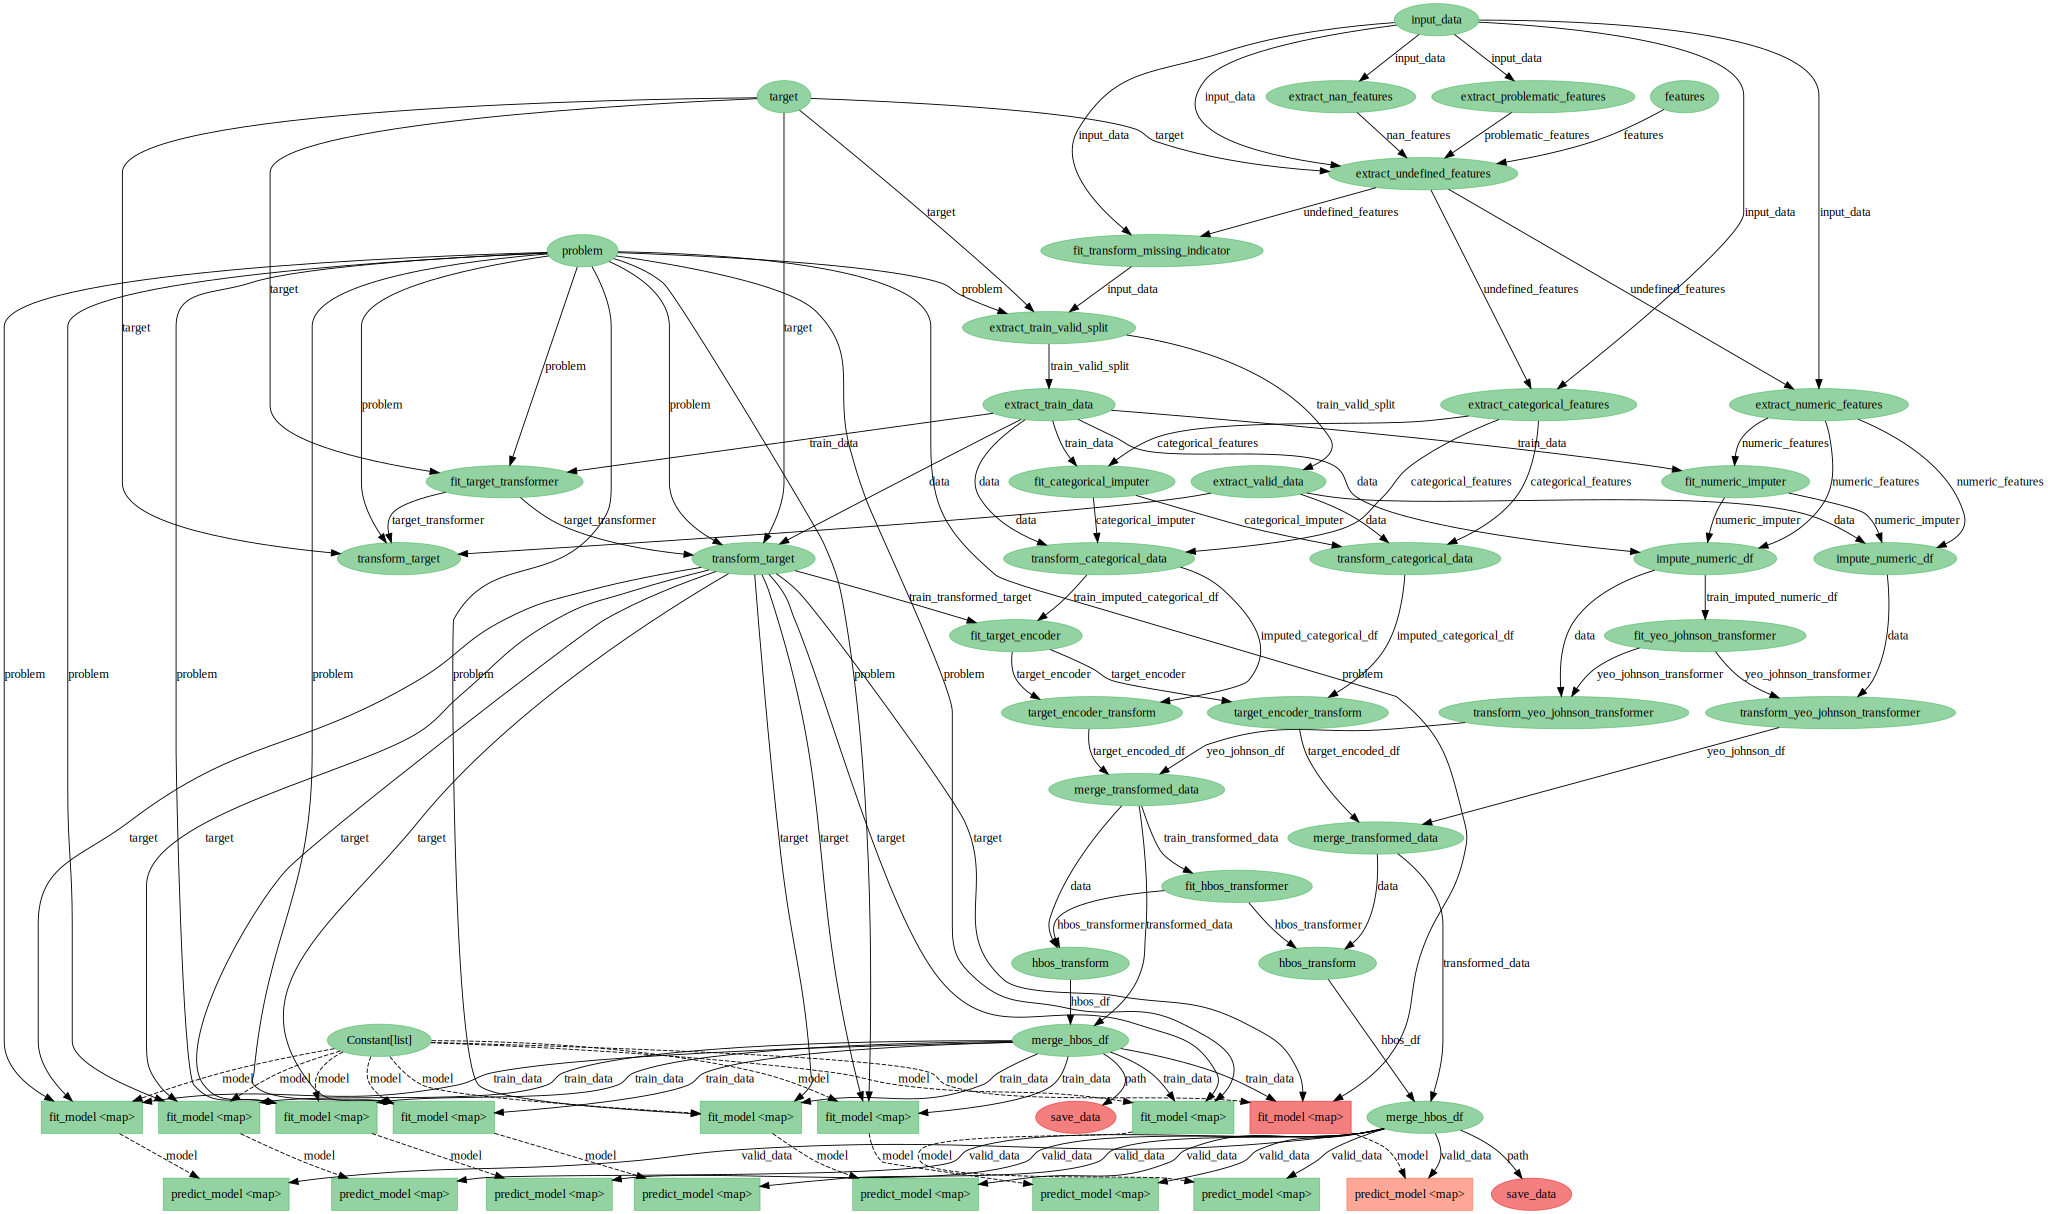

In [9]:
flow.visualize(flow_state=flow_state)